In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset
dataset = load_dataset("community-datasets/offenseval_dravidian", "kannada")

print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6217
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 777
    })
})


In [3]:
from datasets import load_dataset
import re
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = load_dataset("community-datasets/offenseval_dravidian", "kannada")

# Convert the dataset to a list of dictionaries so train_test_split can be applied
train_data = dataset['train']

# Convert the dataset to a list of dicts (this step should be done carefully)
train_data_list = [{'text': item['text'], 'label': item['label']} for item in train_data]

# Split the train data into 90% for training and 10% for testing
train_data_split, test_data_split = train_test_split(train_data_list, test_size=0.1, random_state=42)

# Clean function to preserve emojis and emoticons
def clean_text(text):
    # Remove unwanted characters but keep emojis and emoticons
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    # Keep only letters, numbers, whitespaces, and emojis
    text = re.sub(r'[^a-zA-Z0-9\s\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]', '', text)
    text = text.strip()
    return text

# Apply the cleaning function to the train, test, and validation datasets
train_data_split = [{'text': clean_text(item['text']), 'label': item['label']} for item in train_data_split]
test_data_split = [{'text': clean_text(item['text']), 'label': item['label']} for item in test_data_split]
dataset['validation'] = [{'text': clean_text(item['text']), 'label': item['label']} for item in dataset['validation']]

# Check the cleaned data
print(train_data_split[1])
print(test_data_split[0])
print(dataset['validation'][0])

{'text': 'Haha  nija', 'label': 0}
{'text': '', 'label': 0}
{'text': '100 days pakka', 'label': 0}


In [4]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("community-datasets/offenseval_dravidian","kannada")

# Extract train data
train_data = dataset['train']

# Convert to a list of dictionaries for train_test_split
train_data_list = [{'text': item['text'], 'label': item['label']} for item in train_data]

# Split train data into 90% train and 10% test
train_data_split, test_data_split = train_test_split(train_data_list, test_size=0.1, random_state=42)

# Convert lists of dictionaries to pandas DataFrames
df_train = pd.DataFrame(train_data_split)
df_test = pd.DataFrame(test_data_split)
df_val = pd.DataFrame([{'text': item['text'], 'label': item['label']} for item in dataset['validation']])

# Ensure the DataFrames contain the required columns
required_columns = ['text', 'label']
for df_name, df in zip(['df_train', 'df_test', 'df_val'], [df_train, df_test, df_val]):
    if not all(col in df.columns for col in required_columns):
        raise KeyError(f"{df_name} must contain the columns {required_columns}.")

# Function to extract emojis from the text
def extract_emojis(text):
    emoji_pattern = re.compile(
        r'[\U0001F600-\U0001F64F'  # emoticons
        r'\U0001F300-\U0001F5FF'  # symbols & pictographs
        r'\U0001F680-\U0001F6FF'  # transport & map symbols
        r'\U0001F700-\U0001F77F'  # alchemical symbols
        r'\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
        r'\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
        r'\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
        r'\U0001FA00-\U0001FA6F'  # Chess Symbols
        r'\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
        r'\U00002702-\U000027B0'  # Dingbats
        r'\U000024C2-\U0001F251'  # Enclosed characters
        r']+', flags=re.UNICODE)
    emojis = emoji_pattern.findall(text)
    return ''.join(emojis)

# Function to separate emojis and clean text
def separate_emojis(text):
    emojis = extract_emojis(text)
    # Remove emojis and keep only cleaned text
    text_without_emojis = re.sub(r'[^\w\s,\.!?]', '', text)
    return text_without_emojis.strip(), emojis

# Apply the cleaning and emoji extraction function
df_train['cleaned_text'], df_train['emojis'] = zip(*df_train['text'].map(separate_emojis))
df_test['cleaned_text'], df_test['emojis'] = zip(*df_test['text'].map(separate_emojis))
df_val['cleaned_text'], df_val['emojis'] = zip(*df_val['text'].map(separate_emojis))

# Create separate DataFrames for cleaned text and emojis with labels
df_cleaned_text_train = df_train[['cleaned_text', 'label']].copy()
df_emojis_train = df_train[['emojis', 'label']].copy()

df_cleaned_text_test = df_test[['cleaned_text', 'label']].copy()
df_emojis_test = df_test[['emojis', 'label']].copy()

df_cleaned_text_val = df_val[['cleaned_text', 'label']].copy()
df_emojis_val = df_val[['emojis', 'label']].copy()

# Display sample data
print("Cleaned Text Train Data:")
print(df_cleaned_text_train.head())

print("\nEmojis Train Data:")
print(df_emojis_train.head())

print("\nCleaned Text Test Data:")
print(df_cleaned_text_test.head())

print("\nEmojis Test Data:")
print(df_emojis_test.head())

print("\nCleaned Text Validation Data:")
print(df_cleaned_text_val.head())

print("\nEmojis Validation Data:")
print(df_emojis_val.head())

Cleaned Text Train Data:
                       cleaned_text  label
0                          Hands up      0
1                        Haha  nija      0
2                     1 in trending      5
3   Movie hindi me kb tk aa ne ka h      5
4  Edu charitre srustisuva avatraaa      0

Emojis Train Data:
  emojis  label
0             0
1             0
2             5
3             5
4             0

Cleaned Text Test Data:
                                        cleaned_text  label
0  ವವ ಸಪರ ಅನಲಸಸನಮಮ ದಶ ಓಳಳದ...ಮತ ಜಸತ  ಕಲಸ ಕಮಮ........      0
1  Yalla kannadigarugu ansthithu bere bashe movie...      0
2                   Sir make vidieo on drone prathap      5
3                          Vivek G side ge hogro nim      3
4   ಈ ಯಗದ ಶಕರ ನಗ ಗರ ನನ  all the best from DBOSS fans      0

Emojis Test Data:
  emojis  label
0             0
1             0
2             5
3             3
4             0

Cleaned Text Validation Data:
                                        cleaned_text  label
0         

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load a pre-trained model and tokenizer
model_name = "bert-base-uncased"  # Replace with a model fine-tuned for emojis if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get embeddings for emojis
def get_emoji_embedding(emojis, tokenizer, model):
    if not emojis:  # No emojis provided
        return torch.zeros(768)  # Assuming the model outputs 768-dimensional embeddings
    inputs = tokenizer(emojis, return_tensors="pt", truncation=True, max_length=10)
    outputs = model(**inputs)
    # Use the mean of the last hidden state as the embedding
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings.detach().numpy()

# Apply to your DataFrame
df_emojis_train['emoji_embeddings'] = df_emojis_train['emojis'].map(
    lambda x: get_emoji_embedding(x, tokenizer, model)
)

# Display sample embeddings
print(df_emojis_train[['emojis', 'emoji_embeddings']].head(15))

   emojis                                   emoji_embeddings
0          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
1          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
2          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
3          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
4          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
5          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
6          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
7          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
8          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
9          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
10         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
11         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
12         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
13         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
14         [tensor(0.), tensor(0.), tensor(0.), tensor(0....


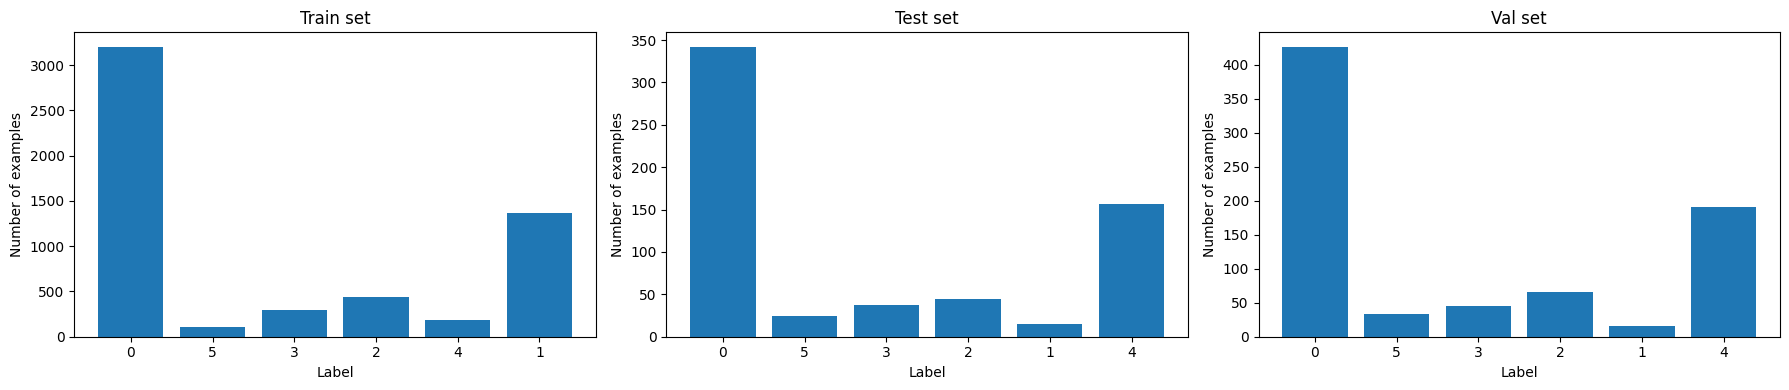

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Plotting the distribution of labels in Train, Test, and Validation datasets
fig = plt.figure(figsize=(18, 4))
titles = ['Train set', 'Test set', 'Val set']

for i, dataf in enumerate([df_train, df_test, df_val]):
    ax = fig.add_subplot(1, 3, i+1)
    Y, labels = pd.factorize(dataf['label'])  # Ensure 'label' column is used
    ax.bar(labels, height=pd.Series(Y).value_counts())  # Bar plot for label count
    ax.set_xticks(ticks=range(len(labels)))  # Position the x-ticks
    ax.set_xticklabels(labels, fontsize=10)  # Set x-tick labels with font size
    ax.set_xlabel('Label')  # X-axis label
    ax.set_ylabel('Number of examples')  # Y-axis label
    ax.set_title(titles[i])  # Title for each plot

# Show the plots
plt.tight_layout()
plt.show()



In [7]:

# Number of samples in Train, Test, and Validation datasets
train_samples = len(df_train)
test_samples = len(df_test)
val_samples = len(df_val)

# Printing the number of samples
print(f"Number of samples in Train set: {train_samples}")
print(f"Number of samples in Test set: {test_samples}")
print(f"Number of samples in Validation set: {val_samples}")

Number of samples in Train set: 5595
Number of samples in Test set: 622
Number of samples in Validation set: 777


In [8]:
from transformers import AutoModel, AutoTokenizer
import pandas as pd
from tqdm import tqdm

# Load the pre-trained MuRIL model and tokenizer
PRE_TRAINED_MODEL_NAME = 'google/muril-base-cased'
muril_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

sample_txt = df_train.iloc[0]['cleaned_text']  # Taking the first sample from the dataset

# Tokenization
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence: {sample_txt}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

# Special tokens
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

# Encoding the sample text
encoding = tokenizer(
    sample_txt,
    max_length=32,
    padding='max_length',  # Updated to avoid deprecated argument
    truncation=True,
    return_tensors='pt'
)

# Print encoding details
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'])
print(len(encoding['token_type_ids'][0]))
print(encoding['token_type_ids'])
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])

# Convert token IDs back to tokens
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

# Assuming df_train exists from previous dataset processing
# Ensure 'text' column is used consistently
if 'text' in df_train.columns:
    column_name = 'text'
else:
    column_name = 'cleaned_text'

# Compute token lengths
token_lens = []
for txt in tqdm(df_train[column_name]):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))


Sentence: Hands up
Tokens: ['Hands', 'up']
Token IDs: [121982, 1533]
[SEP] 105
[CLS] 104
[PAD] 0
[UNK] 100
32
tensor([[   104, 121982,   1533,    105,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0]])
32
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
32
tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
['[CLS]', 'Hands', 'up', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


100%|██████████| 5595/5595 [00:00<00:00, 11516.65it/s]


In [9]:
MAX_LEN = 160
from torch.utils.data import Dataset
import torch
class GPReviewDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts  # Ensure this references 'cleaned_text'
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])  # Ensure it pulls from 'cleaned_text'
        target = self.targets[item]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'tweet_text': text,
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'targets': torch.tensor(target, dtype=torch.long)
        }


In [10]:
from torch.utils.data import Dataset, DataLoader
import torch

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        texts=df.cleaned_text.to_numpy(),  # Updated from 'tuned_tweet' to 'cleaned_text'
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )


In [11]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [12]:
data = next(iter(train_data_loader))
data.keys()


dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])

In [13]:
x = muril_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  token_type_ids=encoding['token_type_ids']
)

In [14]:
import torch
import torch.nn as nn
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes, base):
        super(SentimentClassifier, self).__init__()
        self.muril = base
        self.drop1 = nn.Dropout(p=0.3)
        self.out1 = nn.Linear(base.config.hidden_size, 64)
        self.relu = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.1)
        self.out = nn.Linear(64, n_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        x = self.muril(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = x.pooler_output  # Updated access method
        output = self.drop1(pooled_output)
        output = self.relu(self.out1(output))
        output = self.drop2(output)
        return self.out(output)


In [15]:
import torch
import torch.nn as nn

class_names = ['0', '1', '2', '3', '4', '5']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SentimentClassifier(len(class_names), muril_model)
model = model.to(device)

In [16]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
token_type_ids = data['token_type_ids'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length
print(token_type_ids.shape) # batch size x seq_length


torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16, 160])


In [17]:
model(input_ids, attention_mask, token_type_ids)

tensor([[-0.0965, -0.0582,  0.0004, -0.0445,  0.1261,  0.1067],
        [-0.0873, -0.0533,  0.0018, -0.0411,  0.1217,  0.1022],
        [-0.0904, -0.0591,  0.0027, -0.0407,  0.1254,  0.1092],
        [-0.0939, -0.0569,  0.0013, -0.0412,  0.1268,  0.1050],
        [-0.0911, -0.0556,  0.0027, -0.0404,  0.1259,  0.1055],
        [-0.0903, -0.0559,  0.0020, -0.0391,  0.1260,  0.1001],
        [-0.0906, -0.0522, -0.0039, -0.0338,  0.1228,  0.0994],
        [-0.0904, -0.0607,  0.0007, -0.0440,  0.1194,  0.1077],
        [-0.0937, -0.0570,  0.0007, -0.0425,  0.1214,  0.1052],
        [-0.0921, -0.0565,  0.0028, -0.0405,  0.1271,  0.1047],
        [-0.0926, -0.0571,  0.0034, -0.0413,  0.1244,  0.1013],
        [-0.0853, -0.0610, -0.0061, -0.0371,  0.1132,  0.0963],
        [-0.0898, -0.0544,  0.0005, -0.0382,  0.1244,  0.1017],
        [-0.0940, -0.0533,  0.0035, -0.0407,  0.1261,  0.1056],
        [-0.0964, -0.0529,  0.0030, -0.0404,  0.1277,  0.1051],
        [-0.0896, -0.0543,  0.0033, -0.0

In [18]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask, token_type_ids), dim=1)

tensor([[0.1501, 0.1563, 0.1653, 0.1583, 0.1874, 0.1826],
        [0.1505, 0.1556, 0.1651, 0.1586, 0.1870, 0.1833],
        [0.1500, 0.1563, 0.1655, 0.1580, 0.1871, 0.1831],
        [0.1521, 0.1555, 0.1647, 0.1589, 0.1857, 0.1831],
        [0.1501, 0.1557, 0.1653, 0.1582, 0.1875, 0.1832],
        [0.1504, 0.1564, 0.1648, 0.1592, 0.1860, 0.1832],
        [0.1512, 0.1563, 0.1648, 0.1592, 0.1868, 0.1816],
        [0.1508, 0.1559, 0.1651, 0.1587, 0.1866, 0.1830],
        [0.1510, 0.1555, 0.1657, 0.1582, 0.1871, 0.1826],
        [0.1505, 0.1562, 0.1659, 0.1583, 0.1863, 0.1827],
        [0.1503, 0.1561, 0.1645, 0.1591, 0.1874, 0.1825],
        [0.1512, 0.1561, 0.1647, 0.1592, 0.1858, 0.1830],
        [0.1501, 0.1564, 0.1649, 0.1579, 0.1872, 0.1836],
        [0.1516, 0.1555, 0.1649, 0.1589, 0.1852, 0.1838],
        [0.1507, 0.1562, 0.1646, 0.1584, 0.1871, 0.1830],
        [0.1506, 0.1551, 0.1651, 0.1585, 0.1867, 0.1839]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [19]:
!pip install --upgrade transformers

In [20]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from transformers import  get_linear_schedule_with_warmup

EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [21]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        token_type_ids = d['token_type_ids'].to(device)  # Updated from 'type_ids'
        targets = d["targets"].to(device).long()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [22]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)  # Correct key name
            targets = d["targets"].to(device).long()  # Ensure targets are integers

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

Epoch 1/5
----------


100%|██████████| 350/350 [02:37<00:00,  2.23it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--> Train loss 1.7485 | Accuracy 0.2806 | Precision 0.4664 | Recall 0.2806 | F1 0.2881


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--> Val   loss 1.6327 | Accuracy 0.6551 | Precision 0.5474 | Recall 0.6551 | F1 0.5723

Epoch 2/5
----------


100%|██████████| 350/350 [02:42<00:00,  2.15it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--> Train loss 1.4599 | Accuracy 0.5886 | Precision 0.5083 | Recall 0.5886 | F1 0.4638


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--> Val   loss 1.3421 | Accuracy 0.5483 | Precision 0.3006 | Recall 0.5483 | F1 0.3883

Epoch 3/5
----------


100%|██████████| 350/350 [02:42<00:00,  2.15it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--> Train loss 1.2386 | Accuracy 0.5943 | Precision 0.5427 | Recall 0.5943 | F1 0.4670


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--> Val   loss 1.2283 | Accuracy 0.6152 | Precision 0.5283 | Recall 0.6152 | F1 0.5198

Epoch 4/5
----------


100%|██████████| 350/350 [02:42<00:00,  2.15it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--> Train loss 1.1491 | Accuracy 0.6667 | Precision 0.5710 | Recall 0.6667 | F1 0.5842


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--> Val   loss 1.1855 | Accuracy 0.6718 | Precision 0.5481 | Recall 0.6718 | F1 0.5907

Epoch 5/5
----------


100%|██████████| 350/350 [02:42<00:00,  2.16it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--> Train loss 1.1085 | Accuracy 0.7097 | Precision 0.5973 | Recall 0.7097 | F1 0.6338


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--> Val   loss 1.1724 | Accuracy 0.6821 | Precision 0.5520 | Recall 0.6821 | F1 0.6019


Final Confusion Matrix:


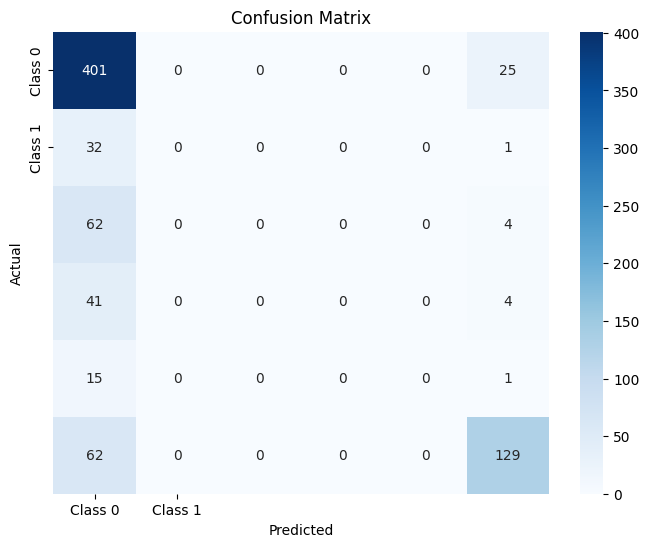

In [23]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Training Parameters
EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

# Loss Function
loss_fn = nn.CrossEntropyLoss().to(device)

# Function to Plot Confusion Matrix (Called Once After Training)
def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Training Function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()

    losses = []
    correct_predictions = 0
    all_preds = []
    all_targets = []

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        token_type_ids = d["token_type_ids"].to(device)
        targets = d["targets"].to(device).long()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    accuracy = correct_predictions.double() / n_examples
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')

    return accuracy, np.mean(losses), precision, recall, f1

# Evaluation Function (Does NOT Plot Confusion Matrix)
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()

    losses = []
    correct_predictions = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            token_type_ids = d["token_type_ids"].to(device)
            targets = d["targets"].to(device).long()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    accuracy = correct_predictions.double() / n_examples
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')

    return accuracy, np.mean(losses), precision, recall, f1, all_targets, all_preds  # Return true & predicted labels for final confusion matrix

# Training Loop
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0

# Class Labels (Update as needed)
class_labels = ["Class 0", "Class 1"]  # Modify based on actual class names

# Variables to Store Predictions for Final Confusion Matrix
final_targets = []
final_preds = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss, train_precision, train_recall, train_f1 = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'\n--> Train loss {train_loss:.4f} | Accuracy {train_acc:.4f} | Precision {train_precision:.4f} | Recall {train_recall:.4f} | F1 {train_f1:.4f}')

    val_acc, val_loss, val_precision, val_recall, val_f1, val_targets, val_preds = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'--> Val   loss {val_loss:.4f} | Accuracy {val_acc:.4f} | Precision {val_precision:.4f} | Recall {val_recall:.4f} | F1 {val_f1:.4f}')
    print()

    history['train_acc'].append(train_acc.cpu().numpy())
    history['train_loss'].append(train_loss)
    history['train_precision'].append(train_precision)
    history['train_recall'].append(train_recall)
    history['train_f1'].append(train_f1)

    history['val_acc'].append(val_acc.cpu().numpy())
    history['val_loss'].append(val_loss)
    history['val_precision'].append(val_precision)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'muril_model_state.bin')
        best_accuracy = val_acc

    # Store Final Predictions for Confusion Matrix
    final_targets = val_targets
    final_preds = val_preds

# **After All Epochs, Show Confusion Matrix**
print("\nFinal Confusion Matrix:")
plot_confusion_matrix(final_targets, final_preds, class_labels)